# Project 1: Mining information from Text Data 
<hr>

## Task 3: Graphs and Social Networks

Using the whole anthologies abstract dataset.

1. From the abstracts part, using two different similarity thresholds (e.g. 0.05, 0.1), create an unweighted network from the obtained similar pairs (use MinHashing or LSH) for each threshold.

2. From the basket list of authors/editors, using A-Priori or PCY, create a weighted network, using the support threshold as weight.

3. Find the communities for the networks obtained in 1. and 2. Comment about the results with respect to the different thresholds and methods. How does it compare with the same analysis using 1-NN done in previous tasks?

4. Use a ready-made software, library or service (eg. gephi) for visualizing one the network in 1. or 2.

<hr>

### 1. From the abstracts part, using two different similarity thresholds (e.g. 0.05, 0.1), create an unweighted network from the obtained similar pairs (use MinHashing or LSH) for each threshold.

In [1]:
from urllib.request import urlopen
from io import BytesIO
from time import time

import pandas as pd
import gzip
import re
import binascii
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import os
import itertools

In [2]:
url  = 'https://aclanthology.org/anthology+abstracts.bib.gz'   # url where the file is stored
filename = 'anthology+abstracts.bib'                           # bib filename
folder   = 'data'                                              # folder name
minimum = 200                                                  # minimum number of words in the abtract to be considered 

# Create the path to store the files
os.makedirs(folder, exist_ok=True)

file = folder + '/' + filename

# Download the file if it doesn't exist locally
if(not os.path.exists(file)):
  print("Downloading " + url + " to /" + folder + "..." )
  with gzip.open(BytesIO(urlopen(url).read()), 'rb') as fb:
    with open(file, 'wb') as f:
        f.write(fb.read())
else:
  print("File " + filename + " already available in folder /" + folder) 

File anthology+abstracts.bib already available in folder /data


In [3]:
# Read and process data
abstracts = []
titles = []
ids = []

with open(file, 'r',errors='ignore') as f:
    for line in f:    
      if '@proceedings{' in line:                                 # key found
        line = re.sub('@proceedings{', '', line)                  # remove 
        line = re.sub(',', '', line)                              # remove 
        line = re.sub('\n', '', line)                             # remove some other characters  
        id = line  
      if '@inproceedings{' in line:                               # key found
        line = re.sub('@inproceedings{', '', line)                # remove 
        line = re.sub(',', '', line)                              # remove 
        line = re.sub('\n', '', line)                             # remove some other characters  
        id = line            
      if ' title = "' in line:                                    # title found
        line = re.sub(' title = "', '', line)                     # remove "title ="
        title = line
      if 'abstract = "' in line:                                  # abstract found
        if len(re.findall('[a-zA-Z]', line)) > .2*len(line):      # ignore non latin
          if len(line) > minimum:                                 # ignore abstracts with less than minimum words (200)
            line = re.sub(' +', ' ', line)                        # remove double spaces
            line = re.sub(' abstract = ', '', line)               # remove "abstract =" 
            line = re.sub('"|\n|,', '', line)                     # remove some other characters  
            line = line.lower()                                   # transform to lower letters             
            abstracts.append(line)
            titles.append(title)
            ids.append(id)

print('Number of abstracts:', len(abstracts))
print('Number of titles:', len(titles))
print('Number of ids:', len(ids))
print('\nAbstract:', abstracts[0])
print('\nTitle:', titles[0])
print('ID:', ids[0])

Number of abstracts: 30115
Number of titles: 30115
Number of ids: 30115

Abstract: offensive language detection (old) has received increasing attention due to its societal impact. recent work shows that bidirectional transformer based methods obtain impressive performance on old. however such methods usually rely on large-scale well-labeled old datasets for model training. to address the issue of data/label scarcity in old in this paper we propose a simple yet effective domain adaptation approach to train bidirectional transformers. our approach introduces domain adaptation (da) training procedures to albert such that it can effectively exploit auxiliary data from source domains to improve the old performance in a target domain. experimental results on benchmark datasets show that our approach albert (da) obtains the state-of-the-art performance in most cases. particularly our approach significantly benefits underrepresented and under-performing classes with a significant improvement o

In [4]:
# Creating a dataframe with ID, abstract and title
data_tuples = list(zip(ids, titles, abstracts))
data = pd.DataFrame(data_tuples, columns=['ID', 'title', 'abstract'])

In [5]:
# Randomly select 1000 rows
data = data.sample(n=1000, random_state=1)
# Reset index
data = data.reset_index(drop=True)
# Get abstracts
abstracts = data['abstract'].tolist()

In [6]:
" Returns the k hasshed shingles of a"
def get_shingles(a, k):
    L = len(a)
    shingles = set()                                   # we use a set to automatically eliminate duplicates
    for i in range(L-k+1):                              
        shingle = a[i:i+k]
        crc = binascii.crc32(shingle.encode('utf-8'))  # hash the shingle to a 32-bit integer
        shingles.add(crc)    
    return shingles

In [7]:
" Minhashing "
def minhash_vectorized(shingles, A, B, nextPrime, maxShingleID, nsig):
    
    signature = np.ones((nsig,)) * (maxShingleID + 1)

    for ShingleID in shingles:
        hashCodes = ((A*ShingleID + B) % nextPrime) % maxShingleID
        np.minimum(signature, hashCodes, out=signature)

    return signature

In [8]:
# get candidate pairs using MinHashing

# parameters
bands = 10         # number of bands
rows = 5           # number of rows
nsig = bands*rows  # number of elements in signature, or the number of different random hash functions

maxShingleID = 2**32-1  # record the maximum shingle ID that we assigned
nextPrime = 4294967311  # next prime number after maxShingleID

A = np.random.randint(0, nextPrime, size=(nsig,),dtype=np.int64)
B = np.random.randint(0, nextPrime, size=(nsig,),dtype=np.int64)

def similar_pairs(s_th,text):
    k_shingles = 5
    signatures = []  # signatures for all abstracts
        

    for abstract in text: 
            
        shingles = get_shingles(abstract, k=k_shingles)                                 # for minHash and LSH
        ShingleID = list(get_shingles(abstract, k=k_shingles))[0]
        signature = minhash_vectorized(shingles, A, B, nextPrime, maxShingleID, nsig)   # for minHash
        signatures.append(signature) 

    Nfiles = len(signatures)    
    candidates = []
    for i in range(Nfiles):
        for j in range(i+1, Nfiles):
            Jsim = np.mean(signatures[i] == signatures[j])        # average number of similar items in 
            if Jsim >= s_th:                                      # two vectors, equivalente to Jaccard 
                candidates.append((i,j))


    return candidates

In [9]:
plt.rcParams['figure.figsize'] = [12, 6]
node_color = 'red'

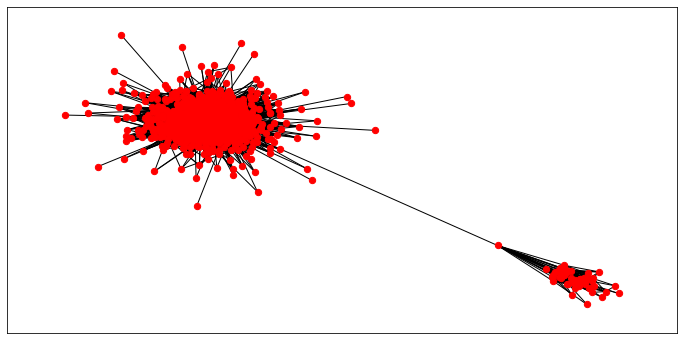

In [10]:
G1 = nx.Graph()
G1.add_edges_from(similar_pairs(0.14,abstracts))
nx.draw_networkx(G1,node_size=40, with_labels = False, node_color = node_color)

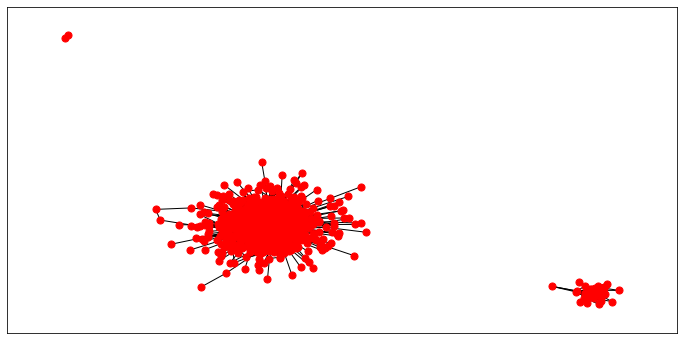

In [11]:
G2 = nx.Graph()
G2.add_edges_from(similar_pairs(0.17,abstracts)) 
nx.draw_networkx(G2,node_size=50, with_labels = False, node_color = node_color)

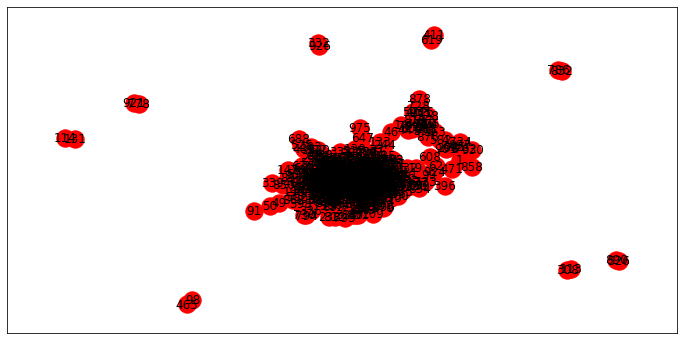

In [12]:
G3 = nx.Graph()
G3.add_edges_from(similar_pairs(0.19,abstracts))
nx.draw_networkx(G3, with_labels = True, node_color = node_color)

<hr>

### 2. From the basket list of authors/editors, using A-Priori or PCY, create a weighted network, using the support threshold as weight.


In [13]:
# Read the date and generate the frozenset
authors_fname = './data/authors.txt'
def readdata(k, fname=authors_fname):    
    with open(fname, "rt", encoding='latin1') as f:
        for line in f:
            C_k  = line.rstrip().split(',')
            for itemset in itertools.combinations(C_k, k):
                    yield frozenset(itemset)  

In [14]:
def get_C(k):
    start = time()
    C = {}
    for key in readdata(k):
        if key not in C:
            C[key] = 1
        else:
            C[key] += 1
    print("Took {}s for k={}".format((time() - start), k))
    return C

In [15]:
supports = [10]
apriori = []
L2s = []
for s in supports:

    print('Threshold = ', s)
    t = time()
    C1 = get_C(1)
    print("C1 contains {} items".format(len(C1)))
    
    # filter stage
    L1 = {}
    for key, count in C1.items():
        if count >= s:
            L1[key] = count
    
    print('{} of those items with > {} occurrences'.format(len(L1),s))

    C2_items = set([a.union(b) for a in L1.keys() for b in L1.keys()]) # List comprehensions in python
    
    # find frequent 2-tuples
    C2 = {}
    for key in readdata(k=2):
        # filter out non-frequent tuples
        if key not in C2_items:
            continue

        # record frequent tuples
        if key not in C2:
            C2[key] = 1
        else:
            C2[key] += 1
    
    print("C2 contains {} items".format(len(C2)))
   
    # filter stage
    L2 = {}    
    for key, count in C2.items():
        if count >= s:
            L2[key] = count        
            with open(filename, 'a') as fi:
                print(key, count, file=fi)    
    #print(L2)
    t2 = round(time() - t,3)
    print('A-priori: {} items with >{} occurrences\n'.format(len(L2), s))    
    apriori.append(str(len(L2)) + ' items with > ' + str(s) + ' occurrences in ' + str(t2) + 's')
    L2s.append(L2) 

Threshold =  10
Took 0.28200435638427734s for k=1
C1 contains 61387 items
4154 of those items with > 10 occurrences
C2 contains 37362 items
A-priori: 1705 items with >10 occurrences



In [16]:
# load data
data = list(L2.items())
an_array = np.array(data)
i=0
for names,weight in an_array:
    l= list(names)
    l.append(weight)
    if i == 0: 
        test = l
        i = 1
    else:
        test = np.vstack([test, l])     
data = test

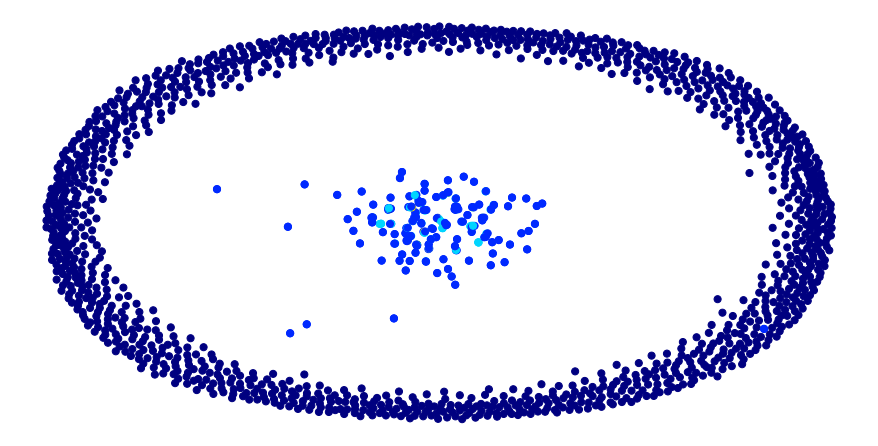

In [17]:
w1 = 21    # threshold's weight 
G4 = nx.Graph()
for n1,n2,w in data:
    G4.add_node(n1)
    G4.add_node(n2)
    if w.astype(int) >= w1:
        G4.add_edge(n1, n2, weight=w)
        
# show graph
node_degrees_1 = nx.degree(G4)
node_degrees = list(dict(node_degrees_1).values())
nx.draw(G4, node_size=50, edge_color="b", with_labels = False, cmap=plt.get_cmap('jet'), node_color = node_degrees)

<hr>

#### 3. Find the communities for the networks obtained in 1. and 2. Comment about the results with respect to the different thresholds and methods. How does it compare with the same analysis using 1-NN done in previous tasks?

# G1

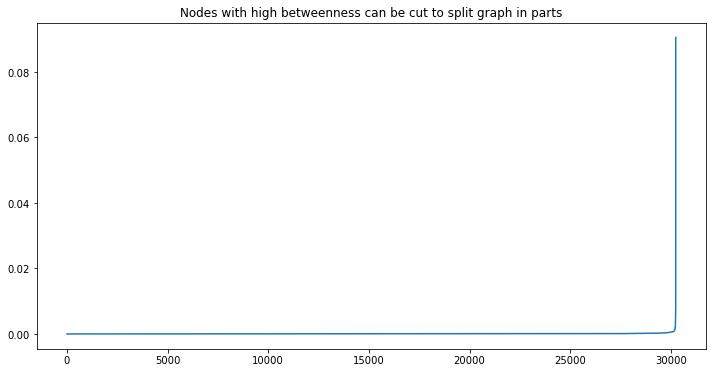

In [18]:
# print betweenness
bt = list(nx.edge_betweenness(G1).values())
plt.plot(range(len(bt)), sorted(bt))
plt.title("Nodes with high betweenness can be cut to split graph in parts")
#plt.ylim([0, 0.02])
plt.show()

In [19]:
# remove edges with betweenness larger than threshold
thr = 0.003 # around 70% of the max value
while True:
    bt = nx.edge_betweenness(G1)
    
    i = np.argmax(list(bt.values()))
    if list(bt.values())[i] < thr:
        break
    n1, n2 = list(bt.keys())[i]
    G1.remove_edge(n1, n2)

# clean graph from single-node components for easy printing
for n, d in list(nx.degree(G1)):
    if d == 0:
        G1.remove_node(n)

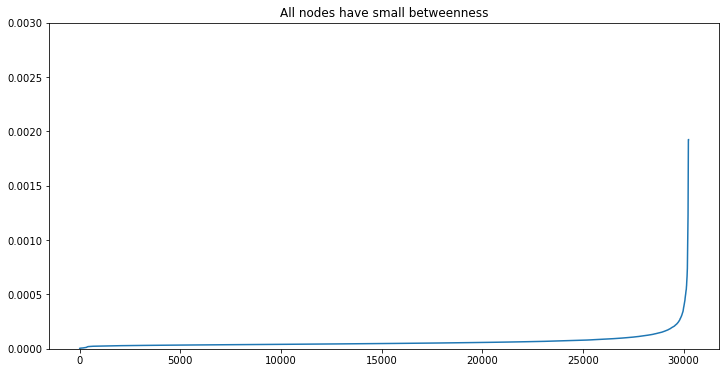

In [20]:
# print new betweenness
bt = nx.edge_betweenness(G1).values()
plt.plot(range(len(bt)), sorted(bt))
plt.title("All nodes have small betweenness")
plt.ylim([0, 0.003])
plt.show()

In [21]:
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

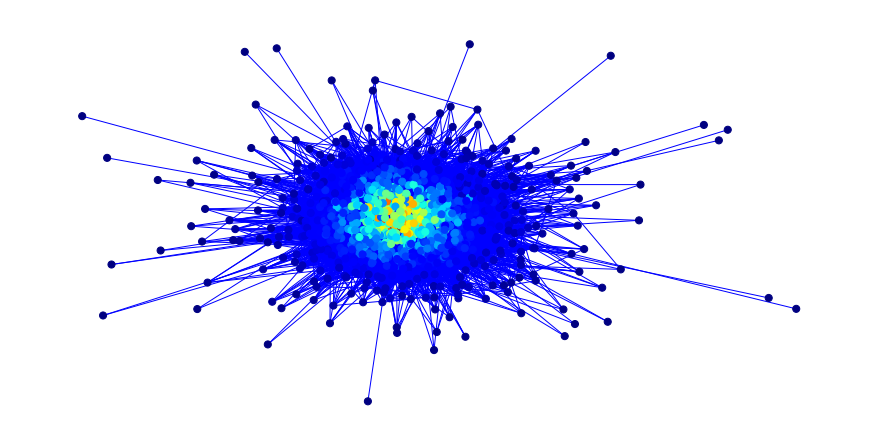

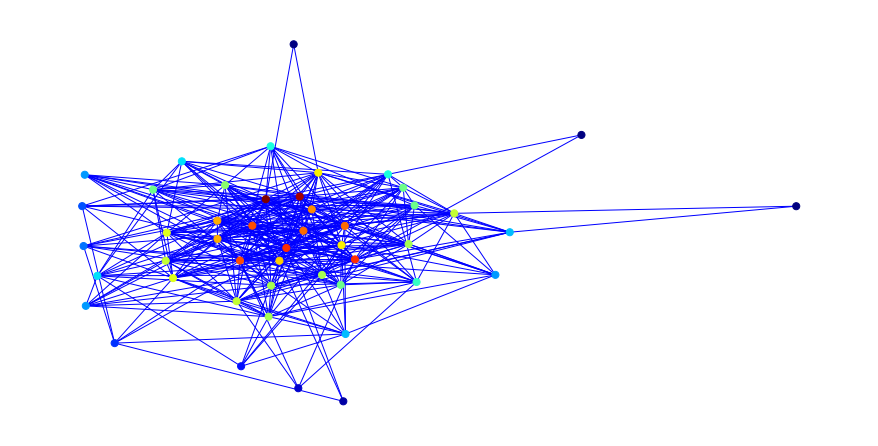

In [22]:
# print found components
#for G1 in nx.connected_component_subgraphs(G):  # for nx < 2.4 version
for G1 in connected_component_subgraphs(G1): # for nx >= 2.4 version
    node_degrees = list(dict(nx.degree(G1)).values())
    nx.draw(G1, node_size=50, edge_color="b", cmap=plt.get_cmap('jet'), node_color = node_degrees)
    plt.show()

# G2

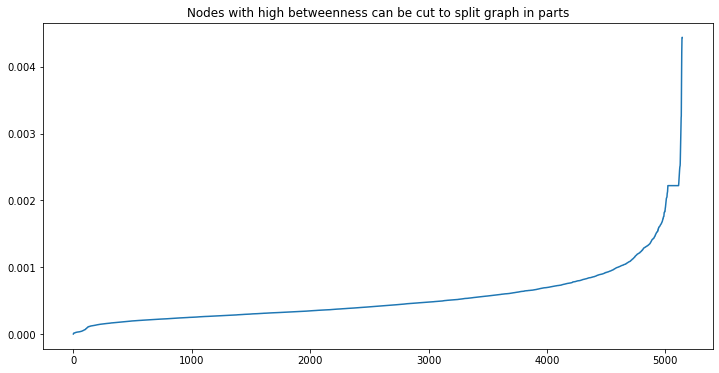

In [23]:
# print betweenness
bt = list(nx.edge_betweenness(G2).values())
plt.plot(range(len(bt)), sorted(bt))
plt.title("Nodes with high betweenness can be cut to split graph in parts")
#plt.ylim([0, 0.02])
plt.show()

In [24]:
# remove edges with betweenness larger than threshold
thr = 0.005 # around 70% of the max value
while True:
    bt = nx.edge_betweenness(G2)
    
    i = np.argmax(list(bt.values()))
    if list(bt.values())[i] < thr:
        break
    n1, n2 = list(bt.keys())[i]
    G2.remove_edge(n1, n2)

# clean graph from single-node components for easy printing
for n, d in list(nx.degree(G2)):
    if d == 0:
        G2.remove_node(n)

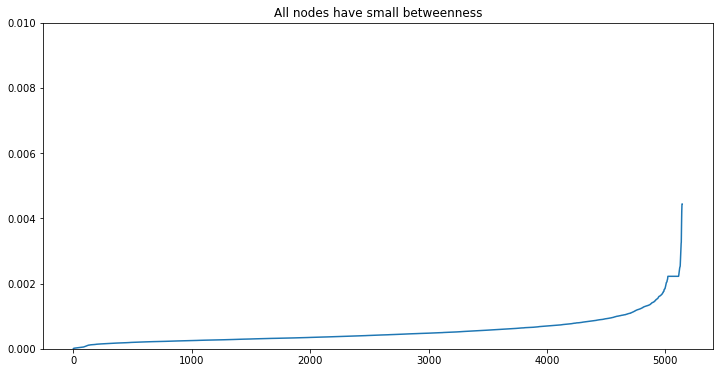

In [25]:
# print new betweenness
bt = nx.edge_betweenness(G2).values()
plt.plot(range(len(bt)), sorted(bt))
plt.title("All nodes have small betweenness")
plt.ylim([0, 0.01])
plt.show()

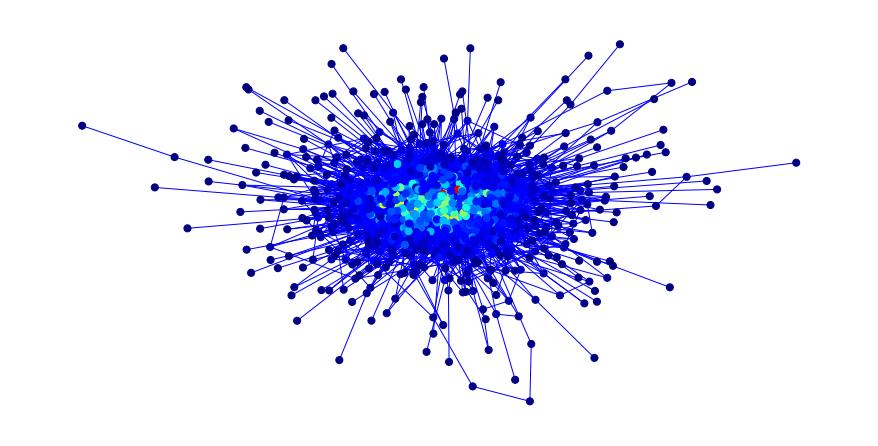

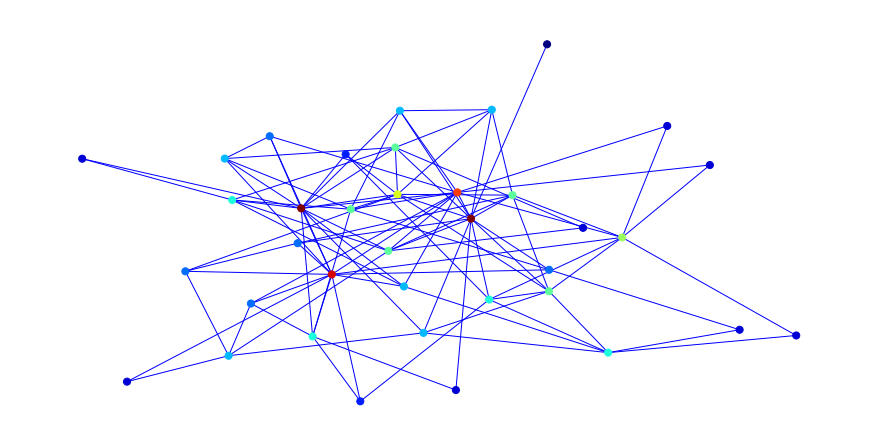

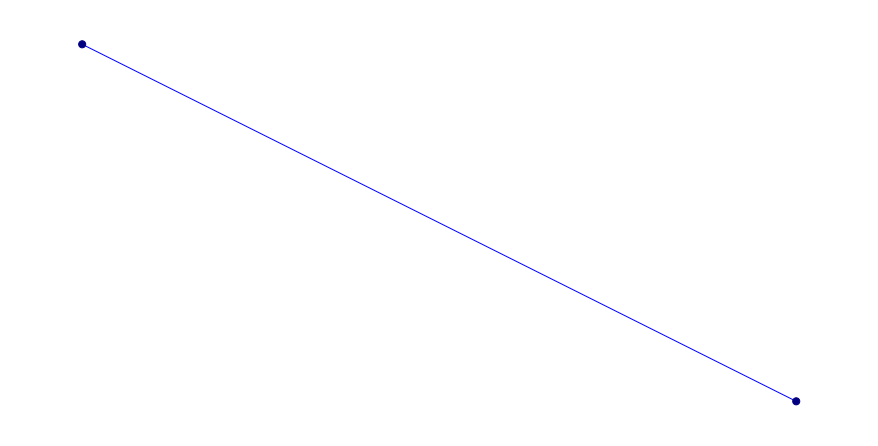

In [26]:
# print found components
#for G2 in nx.connected_component_subgraphs(G):  # for nx < 2.4 version
for G2 in connected_component_subgraphs(G2): # for nx >= 2.4 version
    node_degrees = list(dict(nx.degree(G2)).values())
    nx.draw(G2, node_size=50, edge_color="b", cmap=plt.get_cmap('jet'), node_color = node_degrees)
    plt.show()